In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
%matplotlib inline

### 1. Abrindo Imagem

60.bmp<br>
82.bmp<br>
114.bmp<br>
150.bmp<br>
205.bmp

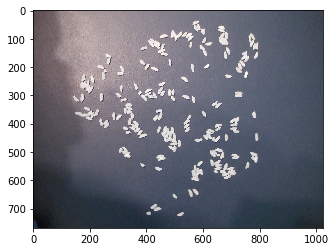

In [17]:
im = cv2.imread("205.bmp")
plt.imshow(im)